# A quick primer on Digital Signal Processing and Filtering

## Paul Anzel

If you're handed a time series, you will sometimes find yourself trying to clean it up before trying to do some more useful feature extraction. Sometimes, you've got interesting stuff happening on a slow time scale (e.g. seasonal variation) and you want to clean out any higher-frequency effects (e.g. day-to-day variations). Or maybe you want to do the opposite. Either way, you'll probably be using techniques that fall under the purview of Digital Signal Processing (DSP) as a first approach.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True, precision=3)
sns.set_style('white')
%matplotlib inline

In [2]:
# Loading up some data
# https://www-nrd.nhtsa.dot.gov/database/VSR/veh/TestDetail.aspx?LJC=10050&existphoto=Y&p_tstno=10050&existreport=Y&r_tstno=10050&existvideo=Y&v_tstno=10050&database=v&tstno=10050
datavals = np.loadtxt('./v10050.099')
t1 = datavals[:, 0]
ax1 = datavals[:, 1]

# Doing some DSP, I'll explain this below
f_nyquist = 0.5/(t1[1] - t1[0])
f_norm = 250/f_nyquist
b, a = signal.butter(3, f_norm)
ax2 = signal.filtfilt(b, a, ax1)

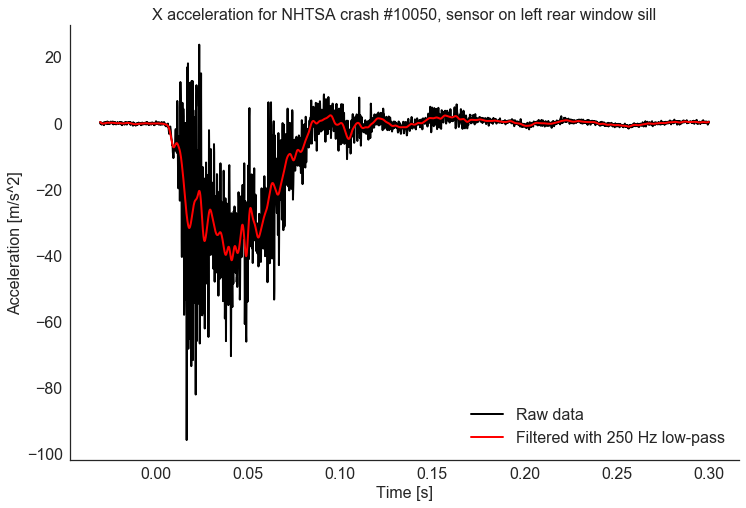

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(t1, ax1, linewidth=2, color='k', label="Raw data")
plt.plot(t1, ax2, linewidth=2, color='r', label="Filtered with 250 Hz low-pass")
plt.legend(loc=4, fontsize=16)
plt.tick_params(labelsize=16)
plt.title("X acceleration for NHTSA crash #10050, sensor on left rear window sill", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Acceleration [m/s^2]", fontsize=16)
sns.despine()

The graph above is a sample example of what I've done with DSP. There is a wealth of crash data from the National Highway Transportation Safety Administration, but a lot of the data is very noisy, and it's difficult to see the overall option. But, by removing all high-frequency motion, I can get a clearer picture of the overall motion of the crash.

## A quick primer on Fourier Analysis

Most of DSP is based around Fourier Analysis, and so if anyone is not familiar with how they work it's worth doing a quick overview. I have a more elaborate set of notes [specifically on these](https://nbviewer.jupyter.org/github/anzelpwj/Stats-week/blob/master/Fourier.ipynb).

The basic idea of Fourier Analysis is this: If I have some continuous function$^*$ $f(t)$ defined over some length $\left[0, T \right)$, I can generate function by adding a series of sines and cosines together of period $n/T$.

$$ f(t) = a_0 + \sum_{n=1}^{\infty} a_n \cos \left( \frac{2 \pi nt}{T}\right) + \sum_{n=1}^{\infty} b_n \sin \left( \frac{2 \pi nt}{T}\right)$$

$^*$ (If $f(t)$ is non-continuous, a few more caveats get added, which I won't go into here.)

Thanks to the identity $e^{i \theta} = \cos(\theta) + i \sin(\theta)$, the sine portion is often put with imaginary numbers, so you could also write

$$ f(t) = \sum_{n=0}^{\infty} F_N e^{2 \pi i n t / T}$$

Where the $F_i$ constants are allowed to be complex. This (or at least the constants $F_N$) is called the __Fourier Series__.

Fundamentally, this means any repeating wave over time $T$ can be thought of as having some offset ($a_0$), fundamental frequency ($a_1$ and $b_1$ constants) and then harmonics. A square wave, for example, will have even $a_n$ values be zero and odd $a_n$ values go as $1/n$, which means that when you listen to a chiptune play a $E \flat$ at 2nd octave, you're also hearing a $B \flat$ at 3rd octave, a $G$ at 4th octave, and other notes as well.

There are a couple of ways the Fourier Series can be extended. First, instead of having $f(t)$ measured on a continuous $t$, we have evenly sampled measurements $f(t_n)$, $t_n = n \Delta t + t_0$. In this case, instead of having an infinite sum of sines and cosines, we'll have a finite sum (basically, anything that has a period shorter than $2 \Delta t$ can't be seen and will appear as [lower-frequency effects](https://en.wikipedia.org/wiki/Aliasing)). Because of this important threshold, we call the frequency $f_N = 1/2 \Delta t$ the __Nyquist Frequency__. This is the most salient thing for computational work, since we often don't get to see what happens to infinite precision but instead we have sampled data. This is the __Discrete Fourier Series__. Note that the 


Second, as $T$ gets bigger and bigger the frequencies get closer and closer together, until when $T$ becomes infinite ($f(t)$ is defined on $(-\infty, \infty)$ the Fourier Series become a continuum, and we call this the __Fourier Transform__.

$$f(t) = \int_{-\infty}^{\infty} e^{2 \pi i \omega t} F(\omega) d\omega$$

(Remember that an integral is basically just kind of sum.)

The function $F(\omega)$ (the __Fourier Representation__) can be calculated by

$$F(\omega) = \int_{-\infty}^{\infty} e^{-2 \pi i \omega t} f(t) dt$$

(Actually, generally calcualating $F$ is called the Fourier Transform, and going from $F$ back to $f$ is the Inverse Fourier Transform).

Fourier Series and Discrete Fourier Series are calculated in a similar fashion. The Discrete Fourier Transform is usually calculated using the __Fast Fourier Transform__, which arranges the order in which sums are calculated to avoid having to make redundant calculations.

I'm going to be a little loose in distinguishing between these three transformations, as functionally they're the same, just on different problem domains.

One __very__ important thing pay attention to for our Fourier representation $F(\omega)$ is __phase__ and __amplitude__. Specifically, if we write

$$ F (\omega) = A(\omega) e^{i \theta (\omega)} $$

Then $A$ is the amplitude and $\theta$ is the phase. Both are important, but while amplitude makes the most intuitive sense (if I have a FT with a big value at $\omega = 50 / s$ and little else, then I'd expect something like $f(t) = 
\sin(50t + \phi)$) the phase is very important for establishing when/where anything of interest happens. The images in the following link are a good example (look at the last few slides)--the photos are turned into their 2D Fourier representations, either the amplitudes are all normalized (set to 1) or the phase is zeroed out, and then the representation is inverted back to a regular image. Note that the phase-zeroing image looks like noise, while you can still see the outlines of the face in the amplitude-normalizing one. *Remember this for later: Phase is important!*

http://www.comm.utoronto.ca/~dkundur/course_info/signals/notes/Kundur_FourierMagPhase.pdf

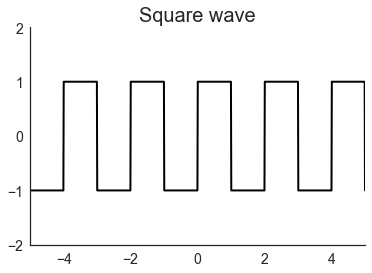

In [4]:
# For a code example, let's look at a simple square wave:

x_square = np.linspace(-5, 5, num=1000)
y_square = np.power(-1, np.floor(x_square))
plt.plot(x_square, y_square, color='k', linewidth=2)
plt.axis((-5, 5, -2, 2))
plt.title('Square wave', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

/Users/panzel/Envs/mm_py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0.5,1,u'Zoomed in')

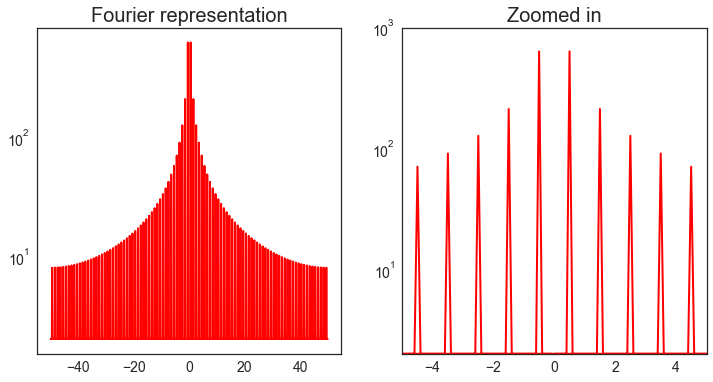

In [5]:
from scipy.fftpack import fft, ifft, fftfreq
y_square_ft = fft(y_square)
x_square_ft = fftfreq(len(x_square), d=(x_square[1] - x_square[0]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].semilogy(x_square_ft, np.abs(y_square_ft), color='r', linewidth=2)
ax[0].tick_params(labelsize=14)
ax[0].set_title("Fourier representation", fontsize=20)
ax[1].semilogy(x_square_ft, np.abs(y_square_ft), color='r', linewidth=2)
ax[1].axis((-5, 5, 0, 1000))
ax[1].tick_params(labelsize=14)
ax[1].set_title("Zoomed in", fontsize=20)

Looking at the coefficients, a square wave can be represented as

$$ \text{Square}(t) = \frac{4}{\pi} \left( \frac{1}{1} \sin (\pi t) + \frac{1}{3} \sin (3 \pi t) + \frac{1}{5} \sin (5 \pi t) + \frac{1}{7} \sin (7 \pi t) + \cdots \right)$$

Taking partial sums of the odd frequencies we get closer and closer to the sine wave.

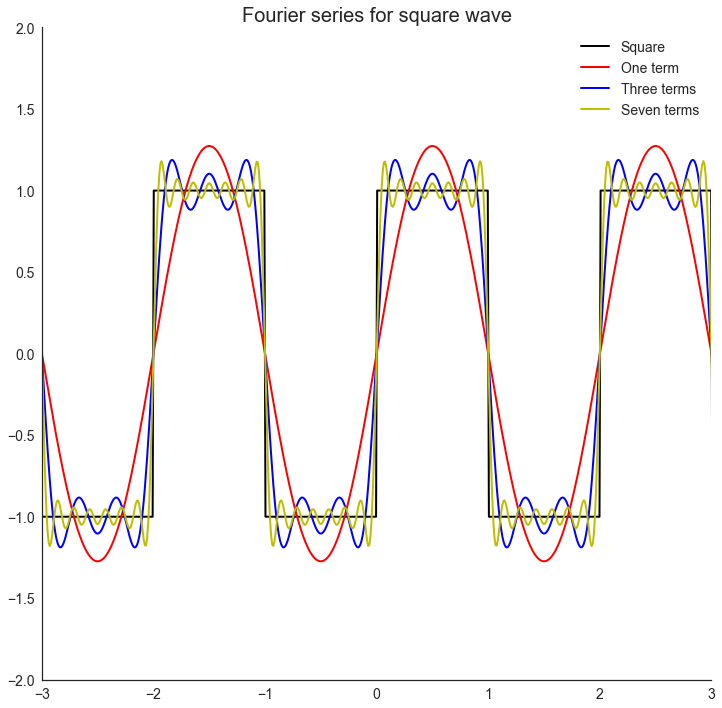

In [6]:
one_sine = (4/np.pi)*(np.sin(np.pi*x_square))
three_sines = (4/np.pi)*(np.sin(np.pi*x_square)
                          + (1.0/3)*np.sin(3*np.pi*x_square)
                          + (1.0/5)*np.sin(5*np.pi*x_square))
seven_sines = (4/np.pi)*(np.sin(np.pi*x_square)
                          + (1.0/3)*np.sin(3*np.pi*x_square)
                          + (1.0/5)*np.sin(5*np.pi*x_square)
                          + (1.0/7)*np.sin(7*np.pi*x_square)
                          + (1.0/9)*np.sin(9*np.pi*x_square)
                          + (1.0/11)*np.sin(11*np.pi*x_square)
                          + (1.0/13)*np.sin(13*np.pi*x_square))

plt.figure(figsize=(12,12))
plt.plot(x_square, y_square, color='k', linewidth=2, label='Square')
plt.plot(x_square, one_sine, color='r', linewidth=2, label='One term')
plt.plot(x_square, three_sines, color='b', linewidth=2, label='Three terms')
plt.plot(x_square, seven_sines, color='y', linewidth=2, label='Seven terms')
plt.axis((-3, 3, -2, 2))
plt.legend(fontsize=14)
plt.title('Fourier series for square wave', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

## A quick primer on convolutions

The other thing we'll need to understand for DSP is convolutions. A convolution is basically [smearing one function by another](https://en.wikipedia.org/wiki/Convolution#/media/File:Convolution_of_spiky_function_with_box2.gif).

You've done this every time you've taken a moving average. Let's say that you've got a 7-day moving average:

$$ y_n = \frac{1}{7}(x_n + x_{n-1} + x_{n-2} + x_{n-3} + x_{n-4} + x_{n-5} + x_{n-6}) $$

If we had some series $K_n = [\ldots, 0, 0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 0, 0, \ldots]$ (or we write the shortened version $K_n = [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]$, without padding by zeros at the end) we could write the moving average as

$$ y_n = \sum_i K_{n-i} x_{i}$$

The series $K$ is called the __kernel__. Another common kernel we see is $[1/\Delta x, -1/\Delta x]$ which gives the derivative, and $[1/(\Delta x)^2, -2/(\Delta x)^2, 1/(\Delta x)^2]$, which gives the second derivative.

For continuous functions, convolution is defined as

$$ y(t) = x(t) * K(t) = \int_{-\infty}^{\infty}x(\tau)K(t - \tau) d\tau$$

In [7]:
# Still a square wave, but I'm bumping down the sample frequency to make the convolution
# obvious.
x_square = np.linspace(-5, 5, num=100)
y_square = np.power(-1, np.floor(x_square))
seven_sample_average = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])/7
y_square_conv = np.convolve(y_square, seven_sample_average, mode="same")

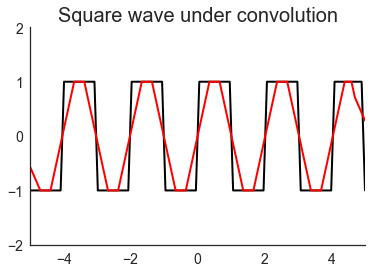

In [8]:
plt.plot(x_square, y_square, linewidth=2, color='k')
plt.plot(x_square, y_square_conv, linewidth=2, color='r')
plt.axis((-5, 5, -2, 2))
plt.title('Square wave under convolution', fontsize=20)
plt.tick_params(labelsize=14)
sns.despine()

You might wonder why we get a minus sign in the convolutions above, as it basically flips the kernel left-to-right (note how my derivative kernel has the positive value first) and seems like a source of confusion. The basic reason is that this gives us a handy mathematical identities--if $\mathcal{F}$ is the Fourier Transform operation then

$$\mathcal{F} (f(t)g(t)) = \mathcal{F}(f(t)) * \mathcal{F}(g(t))$$

$$ \mathcal{F}^{-1} (F(\omega)G(\omega)) = \mathcal{F}^{-1}(F(\omega)) * \mathcal{F}^{-1}(G(\omega))$$

So Fourier Transforms and Inverse Fourier Transforms turn multiplications of functions into convolutions and vice versa. Often you'll have symmetric kernels, so the plus/minus distinction is irrelevant.

## Now we can get into the heart of DSP!

The most basic process in signal processing is this:

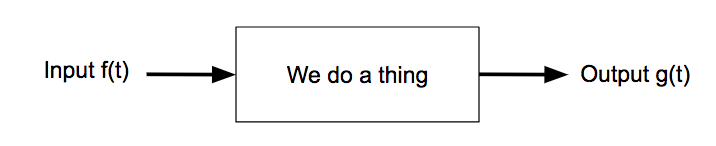

In [9]:
from IPython.display import Image
Image(filename='basic_dsp.png')

This not very helpful. Let's go into more detail.

Our "we do a thing" is called the __Transfer Function__. You could easily imagine all sorts of "things" you could do, but generally we care about systems that are __Linear and Time Invariant__ (LTI). What does this mean?
- If we have two signals $f_1(t)$ and $f_2(t)$ with respective outputs $g_1(t)$ and $g_2(t)$, the output of $a \times f_1(t) + b \times f_2(t)$ should be $a \times g_1(t) + b \times g_2(t)$ (linearity).
- There's no internal state to the "thing" do-er, and it doesn't change over time. The only dependence on $t$ is what we get from $f(t)$ (time invariance).

For LTI systems, the transfer functions we see are basically "multiply your input by something". But we don't just multiply by a number to make our signal bigger or smaller--instead we work in Fourier Space$^*$ by having

$$\mathcal{F}[g(t)](\omega) = H(\omega) \mathcal{F}[f(t)](\omega)$$

And by the Convolution Theorem we have:

$$ g(t) = h(t) * f(t) $$

Often, it may be worth breaking $H(\omega)$ into a fraction $H(\omega) = \frac{B(\omega)}{A\omega)}$ (sometimes you might take a [Padé approximant](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant)), and then we have:

$$ A(t) * g(t) = B(t) * f(t) $$

or, in discrete terms:

$$\sum_k A_{n-k}g_k = \sum_l B_{m-l}f_l$$

*The heart of basic signal processing (and by extension, digital signal processing) is understanding potential $H(\omega)$ expressions, and finding one that does what you want it to do.*

$^*$ Actually, that's a slight lie. Transfer Functions are usually expressed in terms of a Laplace Transform, but that's basically a Fourier Transform rotated 90 degrees in complex space with some differing assumptions. This distinction is unimportant for our discussion.

## Four basic filters

Most basic signal filtering is based on the following filters:
1. __Low-pass__ filter: High frequency noise is removed, while a low frequency signal can pass with (hopefully minimal distortion). the critical frequency between the two is referred as the __cut-off frequency__. My filtering of the NHTSA data at the top of this notebook is one example--I cared about the bulk movement of the car (which is relatively slow) compared to the high-frequency rattling of the accelerometer.
2. __High-pass__ filter: The opposite of low-pass, where slow movements are cancelled out while high-speed movements are kept. As an example, I might use this if I wanted to look at how sales figures changed over a week while removing slow seasonal variations.
3. __Band-pass__ filters: I only care about a small range of frequencies, while ignoring those above this and below it. When you tune a radio to a station, you're using a band-pass to ignore stations above and below your chosen station on the dial.
4. __Band-stop__ filters: The opposite of band-pass filters, where you keep all but a small band of frequencies. If you were recording someone's voice but wanted to get rid of the 60 Hz hum of the florescent lights in the room, you would use this.

We generally demonstrate how filters work by plotting their Fourier Transform (or often, just the magnitude - this is called the  __gain__), in what's called a __Bode plot__. Examples are shown below.

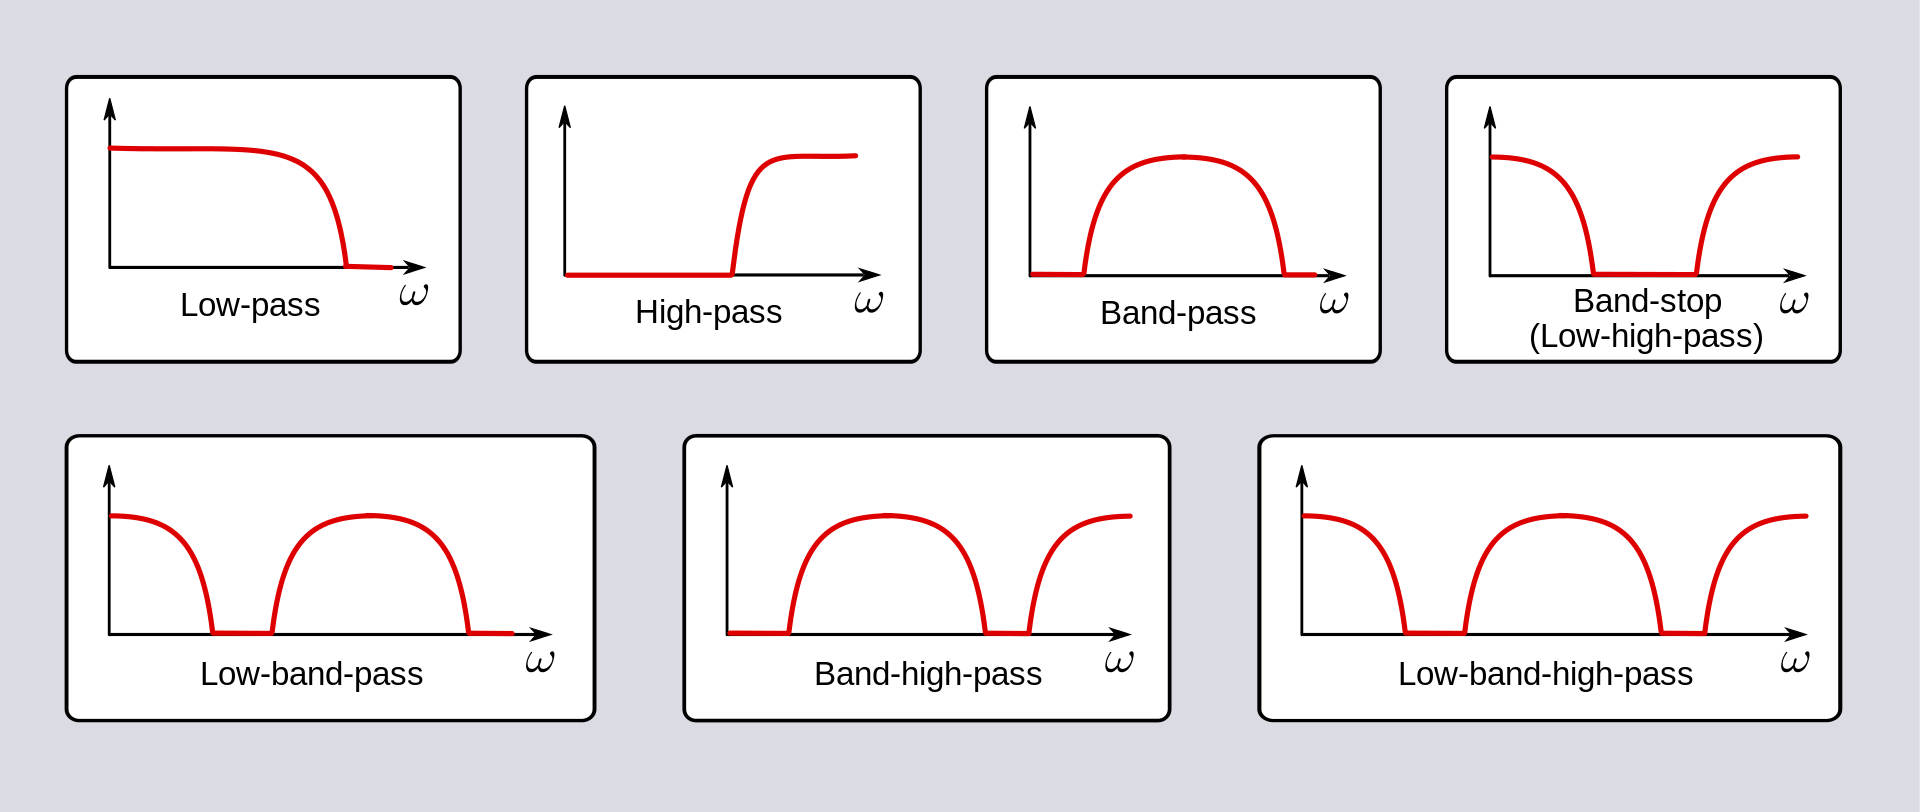

In [10]:
# Comparison of various filters
# https://en.wikipedia.org/wiki/Filter_(signal_processing)

Image(filename='different_filters.png')

You could easily imagine ideal versions of each type of filter that have no distortion in the frequencies you keep and perfect cancellation of the frequencies you want to reject, but those require infinitely long convolutions to calculate$^*$ and, in practice with DSP, end up giving you lots of weird oscillations. So the various filters you do use (e.g. Butterworth, Tchebyshev type 1 and 2, Bessel, etc) end up giving you practical tradeoffs between not distorting your signal and cancelling out the signals you want.

$^*$You also couldn't practically realize these if you were using analog electronics, which was a problem back in signal processing's traditional roots but is less of a problem if we're just adding and multiplying a bunch of numbers.

Below we have some sample low pass filter gains (change in amplitude), with a cut-off frequency $f_0$. Note the ripple in the Tchebyshev and Elliptic filters, but that the Butterworth filter doesn't cut off frequencies above $f_0$ as effectively.

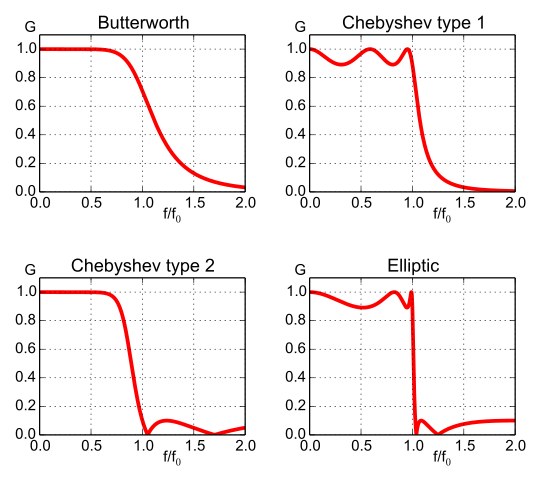

In [11]:
# https://en.wikipedia.org/wiki/Butterworth_filter
# Gain = G, cutoff-frequency = f_0
Image(filename='different_low_pass_filters.png')

## Don't forget about phase!

The plots above show the amplitudes of the transfer functions for these filters, but critically missing from the plots is the phase response. As mentioned before, *phase is important*! For a lot of the standard filters, the phase response is flat until you get close to the cut-off frequency/frequencies, at which point things start moving around. But, if you care about where/when something happens, you need to be very careful about the phase.

As an illustration, let's start with a noisy Gaussian.

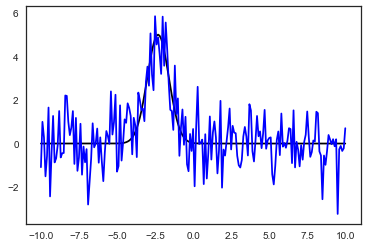

In [12]:
np.random.seed(123)
t = np.linspace(-10, 10, 201)
x = 5*np.exp(-np.power(t + 2.3, 2))
x_noise = x + np.random.randn(len(t))
plt.plot(t, x, color='k')
plt.plot(t, x_noise, color='b')

Applying a 3rd order Butterworth Filter (Bode plot below):

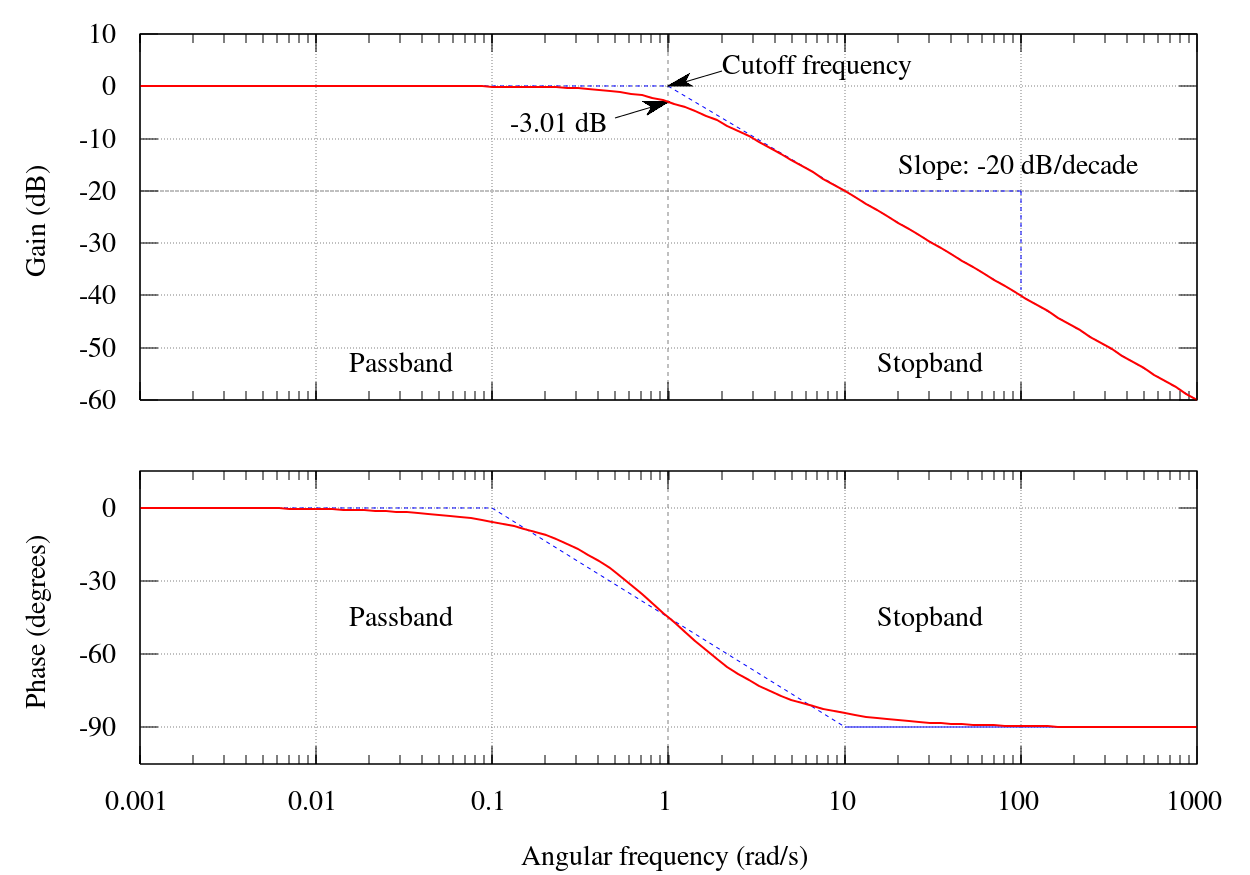

In [22]:
# https://en.wikipedia.org/wiki/Butterworth_filter#/media/File:Butterworth_filter_bode_plot.svg
Image(filename='Butterworth_bode.png')

In [19]:
b, a = signal.butter(3, 0.05)
# mmm, butter
print(b)
print(a)

zi = signal.lfilter_zi(b, a) # These are initial conditions, since at the first data point we don't have data
                             # for our convolution otherwise.
z, _ = signal.lfilter(b, a, x_noise, zi=zi*x_noise[0])

[ 0.     0.001  0.001  0.   ]
[ 1.    -2.686  2.42  -0.73 ]


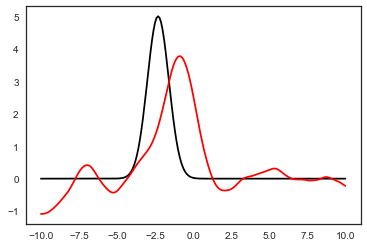

In [18]:
plt.plot(t, x, color='k')
plt.plot(t, z, 'r')

We can clearly see that the peak of the filtered data heavily lags the original peak. If we had something with a much larger cut-off frequency (so more of the signal is in the flat phase area):

In [20]:
b, a = signal.butter(3, 0.5)
print(b)
print(a)

zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, x_noise, zi=zi*x_noise[0])

[ 0.167  0.5    0.5    0.167]
[ 1.    -0.     0.333 -0.   ]


Text(0.5,1,u'Butterworth filter, high $f_0$')

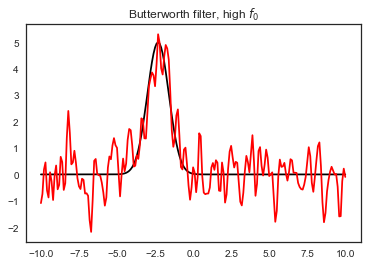

In [26]:
plt.plot(t, x, color='k')
plt.plot(t, z, 'r')
plt.title(r"Butterworth filter, high $f_0$", fontsize=20)
sns.despine()

While we haven't filtered out much noise, the location of the peak is still right where we expect it.

If you're filtering streaming in data and care greatly about specific times for when things come in, you may be stuck setting your cut-off frequency fairly high and accepting some noise in order to find the desired signal.

On the other hand, if you've got your set of data already, one way to completely cancel out the phase distortion is to run the filter twice on the data, once going forwards and the other time going backwards across the data. Then you end up with the gain squared, and phase stuff can cancel out. Scipy's `filtfilt` function does this for you.

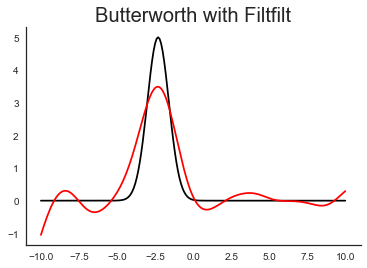

In [27]:
b, a = signal.butter(3, 0.05)
y = signal.filtfilt(b, a, x_noise)
plt.plot(t, x, color='k')
plt.plot(t, y, 'r')
plt.title("Butterworth with Filtfilt", fontsize=20)
sns.despine()

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
np.random.seed(123)
t = np.linspace(-10, 10, 201)
x = 5*np.exp(-np.power(t + 2.3, 2))
x_noise = x + np.random.randn(len(t))
plt.plot(t, x, color='k')
plt.plot(t, x_noise, color='b')

In [ ]:
b, a = signal.butter(3, 0.05)
# mmm, butter

In [ ]:
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, x_noise, zi=zi*x_noise[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, x_noise)

In [ ]:
plt.plot(t, x, color='k')
plt.plot(t, z, 'r--', t, z2, 'r:', t, y, 'r')

In [ ]:
a

$sinc(x) = \prod_{k=1}^{\infty} \left( 1 - \frac{x^2}{k^2 \pi^2}\right) \approx \prod_{k=1}^{\textit{large k}} \left( 1 - \frac{x^2}{k^2 \pi^2}\right) =\left( \frac{1}{k \pi} \right)^{2 \times \textit{large k}} \prod_{k=1}^{\textit{large k}} \left( x - k \pi\right) \left( x + k \pi\right)$